In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
def draw_linear(
    x: np.ndarray, 
    y_actual: np.ndarray,
    w_actual: np.ndarray,
    y_predict: np.ndarray = None,
    w_predicted: np.ndarray = None
):
  linear_grid = np.linspace(x.min(), x.max(), 100)
  
  if y_predict is not None:
    plt.scatter(x, y_predict, label="predict")
  
  if w_predicted is not None:
    plt.plot(linear_grid, linear_grid * w_predicted[0] + w_predicted[1], label="predicted linear")
    
  plt.scatter(x, y_actual, label="true")
  plt.plot(linear_grid, linear_grid * w_actual[0] + w_actual[1], label="actual linear")

  plt.title("Dependecies")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()

In [98]:
n_samples = 1024 * 4
n_features = 1
n_targets = 1

In [99]:
bias_actual = 32.
noise = 64

In [100]:
X, Y, coeff_actual = make_regression(
  n_samples=n_samples,
  n_features=n_features,
  n_informative=n_features, 
  n_targets=n_targets,
  coef=True,
  bias=bias_actual,
  noise=noise, random_state=42
)
coeff_actual = [coeff_actual.tolist()] if coeff_actual.shape == () else coeff_actual

Y = Y.reshape((Y.shape[0], 1))

In [101]:
X.shape, Y.shape

((4096, 1), (4096, 1))

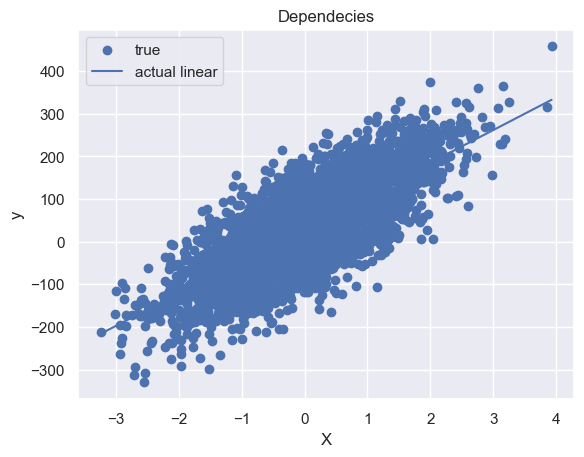

In [102]:
if n_features == 1 and n_targets == 1:
  draw_linear(X, Y, np.array([*coeff_actual, bias_actual]))

In [103]:
X_train, X_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=42
)

In [104]:
n_clients = 50

In [105]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
from common.distributor import UniformDataDistributor, HomogenousDataDistributorComplex
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold

In [107]:
from function.vanilla import MSERidgeLinear, MSELassoLinear

In [108]:
distributor = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=n_clients,
  iid_fraction=0.3
)
mse = MSERidgeLinear(n_features=n_features)
model = Model(mse, distributor, save_history=True)

In [109]:
len(model.server.history), len(model.clients[0].history)

(0, 0)

In [110]:
model.clients.shape

(50,)

In [111]:
from common.pipeline import Pipeline


For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 32, 'eta': 0.0001}:
mse : 4249.694845887243
mae : 52.6287771354299
mape : 3.1159674048020696

For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 128, 'eta': 0.0001}:
mse : 4256.574443947678
mae : 52.70053658142212
mape : 2.9207566295409335
done


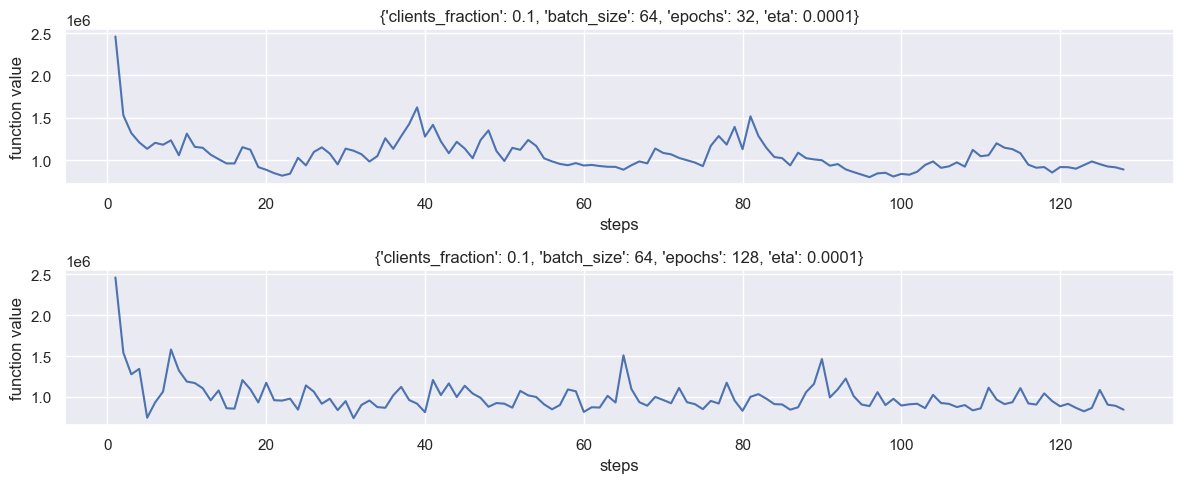

In [112]:
parameters = {
  "clients_fraction": [0.1],
  "batch_size": [64],
  "epochs": [32, 128],
  "rounds": [128],
  "eta": [1e-4],
}
metrics = {
  "mse" : mean_squared_error, 
  "mae" : mean_absolute_error, 
  "mape" : mean_absolute_percentage_error
}

pipeline = Pipeline(
  model=model,
  optimizer=Scaffold,
  parameters=parameters,
  metrics=metrics,
  X_val=X_test,
  y_val=y_test
)

best, best_params = pipeline.run(
  choose_best_by="mae",
  show_global_history=True
)
print("done")

In [97]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[[43.65103711]
 [34.2216761 ]]
[[49.61875268]
 [36.87016141]]
[[49.72205058]
 [35.13730838]]
[[43.9042391 ]
 [40.79289764]]
[[41.91280197]
 [36.79974582]]
[[48.60219266]
 [40.38849694]]
[[57.10167553]
 [35.36157397]]
[[45.33256411]
 [33.6291201 ]]
[[51.52143462]
 [35.38280654]]
[[46.76023029]
 [37.20661188]]


array([[51.52143462],
       [35.38280654]])

In [20]:
best_params

{'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 32, 'eta': 0.0001}

  MSE: 4209.826933693539
  MAE: 52.513722693791365
  MAPE: 3.313600092512235


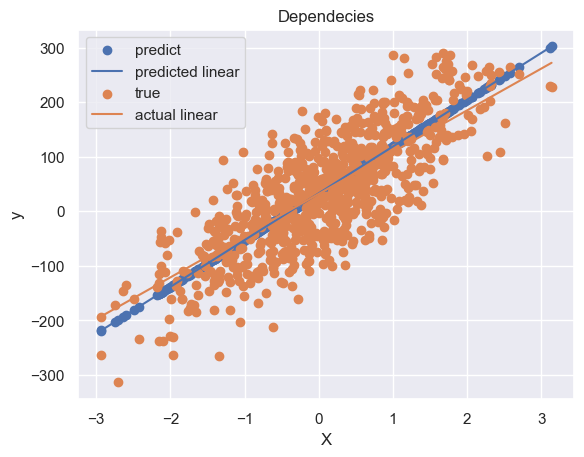

In [26]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X_test, y_test, np.array([*coeff_actual, bias_actual]),
    best.server.function.predict(X_test), best.server.function.weights()
  )
print(f"\
  MSE: {mean_squared_error(y_test, best.server.function.predict(X_test))}\n\
  MAE: {mean_absolute_error(y_test, best.server.function.predict(X_test))}\n\
  MAPE: {mean_absolute_percentage_error(y_test, best.server.function.predict(X_test))}\
")

In [ ]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

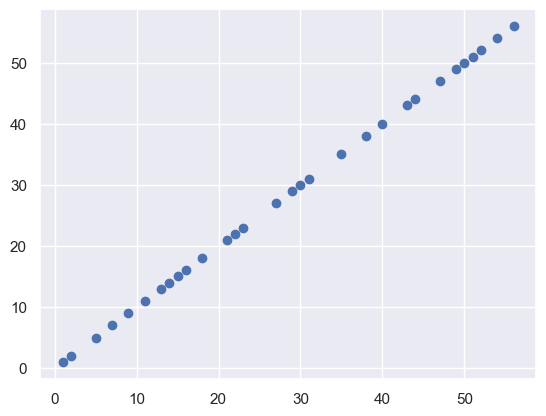

In [ ]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [ ]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

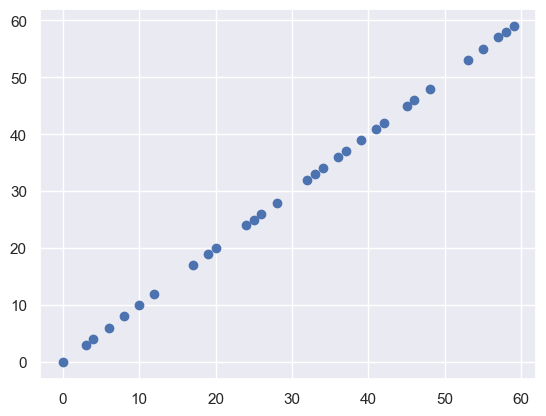

In [ ]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [ ]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from common.distributor import (
  UniformDataDistributor, HomogenousDataDistributor, HomogenousDataDistributorComplex
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

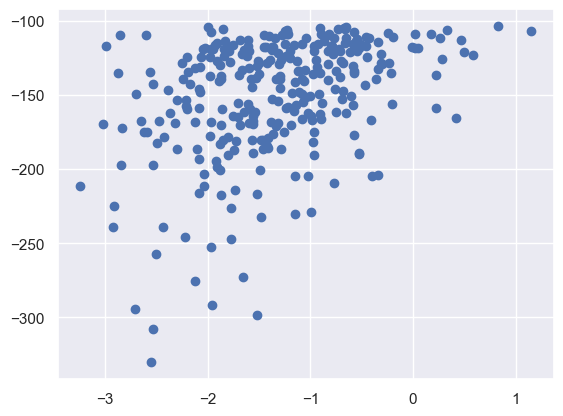

In [ ]:
distrotest = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=10,
  iid_fraction=0
)
x, y = distrotest.server_portion()
plt.scatter(x, y)

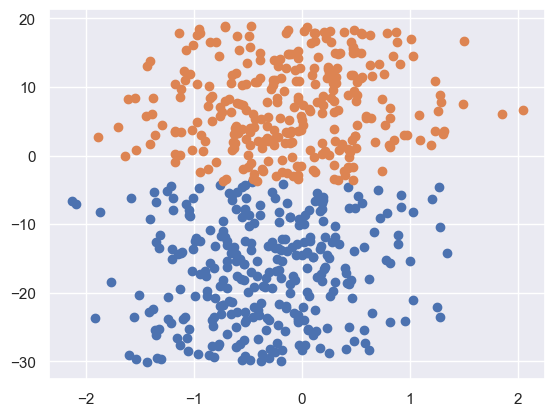

In [ ]:
k = 0
for x, y in distrotest.clients_portions():
  if k == 2 or k == 3:
    plt.scatter(x, y)
  k += 1


In [637]:
import torch
from torch import nn

In [638]:
def check_weights(model: nn.Module):
  for i, parameters in enumerate(model.parameters()):
    print(f"\noriginal: {parameters=}\ntheory: {w[i]}\n---")

In [639]:
def step(model: nn.Module, theory_grads, w, old_w):
  with torch.no_grad():
    for i, parameters in enumerate(model.parameters()):
      w[i] -= 1e-3 * theory_grads[i](old_w[0], old_w[1], x, y)
      parameters -= 1e-3 * parameters.grad

In [640]:
theory_model_grad_loss_w1 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w2 * x
theory_model_grad_loss_w2 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w1 * x
theory_grads = [theory_model_grad_loss_w1, theory_model_grad_loss_w2]

In [641]:
model = nn.Sequential(
    nn.Linear(1, 1, bias=False), 
    nn.Linear(1, 1, bias=False), 
)
mse: nn.MSELoss = nn.MSELoss()
theory_model_loss = lambda w1, w2, x, y: (y - w1 * w2 * x) ** 2
mse

MSELoss()

In [642]:
w = [0. for _ in range(len(model))]
x = 1
y = 1

In [643]:
for i, parameters in enumerate(model.parameters()):
  w[i] = parameters.tolist()[0][0]
check_weights(model)


original: parameters=Parameter containing:
tensor([[0.6322]], requires_grad=True)
theory: 0.6321828365325928
---

original: parameters=Parameter containing:
tensor([[0.2206]], requires_grad=True)
theory: 0.22063219547271729
---


In [665]:
predictions = model.forward(torch.Tensor([[x]]))
y_tensor =  torch.Tensor([[y]])

loss = mse(predictions, y_tensor)
loss, theory_model_loss(w[0], w[1], x, y)

(tensor(0.7365, grad_fn=<MseLossBackward0>), 0.7365092664805802)

In [666]:
loss.backward()

In [667]:
for theory_grad, parameters in zip(theory_grads, model.parameters()):
  print(f"{parameters=}")
  print(f"{parameters.grad=}")
  print(f"theory_grad: {theory_grad(w[0], w[1], x, y)}\n---")

parameters=Parameter containing:
tensor([[0.6333]], requires_grad=True)
parameters.grad=tensor([[-0.3843]])
theory_grad: -0.3842943571190587
---
parameters=Parameter containing:
tensor([[0.2239]], requires_grad=True)
parameters.grad=tensor([[-1.0870]])
theory_grad: -1.0870432259818936
---


In [668]:
from copy import copy

old_w = copy(w)

In [669]:
step(model, theory_grads, w, old_w)

In [670]:
check_weights(model)


original: parameters=Parameter containing:
tensor([[0.6337]], requires_grad=True)
theory: 0.6337108677079405
---

original: parameters=Parameter containing:
tensor([[0.2250]], requires_grad=True)
theory: 0.2249823056544184
---


In [664]:
model.zero_grad()

In [620]:
w[0] * x, w[1] * x

(-1245.8303842033965, 2166.022646392367)